
# Deep hedging

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [ ]:
rng = np.random.default_rng()

In [ ]:
# parametres
r = 0.1
sigma = 0.25
x0 = 100.
K = 100.
N, T = 10, 1

In [ ]:
from scipy.stats import norm

def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [ ]:
price_call_BS(x0, T, r, sigma, K)

np.float64(14.9757907783113)

In [ ]:
dprice_call_BS(x0, T, r, sigma, K)

np.float64(0.7002084045313042)

In [ ]:
M = int(1e5)

In [ ]:
def simu_S(N, M, x0 = x0, r = r, sigma = sigma, T = T):
    """
    fonction permettant de simuler des trajectoires sur sous jacent (sous Q)

    paramètres :
    - N (int) : nombre de points considéres par trajectoire
    - M (int) : nombre de trajectoires
    - x0 (float) : valeur initiale de S
    - r (float) : taux sans risque
    - sigma (float) : volatilité sur sous jacent
    - T (float) : limite supérieur de l'intervale de simulation

    retourne :
    - sample (tableau de float de taille NxM) : ensemble des trajectoires

    """
    dt = T / N
    brown_acc = np.sqrt(dt) * np.random.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N, M))
    sample[0] = x0
    for n in range(1, N):
        sample[n] = sample[n - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * brown_acc[n - 1])
    return sample

## Implémentation du réseau de Neurones

Un call est répliqué avec un portefeuille autonfinançant $V_t = \delta_t(S_t) S_t + \beta_t(S_t) S^0_t$. Dans le cas classique, $\delta_t(x)$ correspond à la dérivée du prix du call par rapport au sous jacent. L'idée est ici d'apprendre les fonctions $\delta_{t_i}$ ($i  \in {0, 1, ..., N - 1}$) avec N réseaux de neurones, en cherchant à minimiser $E((V_T - (S_T - K)_+)^2)$.

In [ ]:
import torch
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


Le réseau de neurone est créé pour approximer une fonction $x \rightarrow δ_t(x)$ à valeur dans $[0,1]$. Il est donc naturel d'utiliser une fonction d'activation à valeur dans $[0,1]$ comme une sigmoid. Les fonctions attendues étant plutot régulière, on remplace les fonctions ReLu par des fonctions SiLU.

On crée ensuite une fonction PnL (reprise au notebook deep hedging).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [nn.Linear(input_size, layer_sizes[0]), nn.SiLU()]
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out1 = self.linear_relu_stack(x)
        out2 = torch.sigmoid(out1)
        return out2

In [ ]:
def pnl_value(v0, X, X_scaled, hedge_functions):
    """
    fonction qui calcule le PnL de la vente d'un associé à une converture donnée.

    paramètres :
    v0 (float) : valeur initiale du portefeuille
    X (matrice de float de taille (N+1)xM) : matrice contenant les trajectoires de l'actif risqué actualisé
    X_scaled (matrice de float de taille (N+1)xM) : matrice contenant les trajectoires de l'actif risqué actualisé et scalé (pour le NN)
    hedge_functions (N fonction de R -> [0,1]) : ensemble des fonctions remplaçant les deltas.

    sortie :
    V[N] (float) : PnL final associé à la stratégie de converture

    """
    v = torch.zeros_like(X, dtype=torch.float32).to(device)
    N, M = X.shape

    N = N - 1

    x_prev = X_scaled[0][:, None]
    hedge_output = hedge_functions[0](x_prev).squeeze()

    v[0] = v0 - hedge_output * X[0]

    # mise en mémoires des différents deltas.
    hedge_list = [hedge_output]

    for i in range(1, N):
        # à chaque intant t_i, la fonction \delta_t_i utilise x_i pour décider du rebalancement.
        x_prev = X_scaled[i][:, None]
        hedge_output = hedge_functions[i](x_prev).squeeze()

        v[i] = v[i-1] - (hedge_output - hedge_list[-1]) * X[i]
        hedge_list.append(hedge_output)

    v[N] = v[N-1] + hedge_list[-1] * X[N] - torch.max(X[N] - np.exp(-r * T)*K, torch.tensor(0.0).to(device))
    return v[N]


Les réseaux de neurones sont d'une taille réduite (maximum $[32, 32]$) car les fonctions à apprendre ne sont a priori pas très complexes. De plus, cela permet de limiter le nombre de paramètres à apprendre (en tout, #{paramètres d'un réseau} * N). Finalement, cela permet d'éviter un éventuel overfitting.

Etant donnée la similarité entre les différentes fonctions à estimer, on aurait aussi pu créer un seul grand réseau de neurone prenant en argument x et t (plutôt que juste t). En particulier, dans notre cas le nombre de paramétre a optimiser est proportionel à N, ce qui est vite contraingnant.

On entraine l'ensemble des réseaux de neurones en même temps, en minimisant $E(PnL)^2$.

In [ ]:
# création des trajectoires et actualisation
samples = simu_S(N+1, M)
samples_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * samples
X = torch.from_numpy(samples_act.astype(np.float32)).to(device)

mean_val = X.mean()
std_val = X.std()
X_scaled = (X - mean_val)/(std_val)

# création de l'ensemble des fonctions couvertures.
hedge_functions = [NeuralNetwork(1, [32, 32], 1).to(device) for _ in range(N+1)]

In [ ]:
n_epochs = 20
batch_size = 4*1024
learning_rate = 1e-3

In [ ]:
optimizer = torch.optim.Adam(
    [param for hedge_function in hedge_functions for param in hedge_function.parameters()],
    lr=learning_rate, weight_decay=1e-4)

criterion = nn.MSELoss()

with tqdm(range(n_epochs)) as nrange:
    for n in nrange:
        indexes = torch.randperm(M)

        for k in range(M // batch_size):
            idx = indexes[k * batch_size : (k + 1) * batch_size]

            y_real = pnl_value(price_call_BS(x0, T), X[:,idx], X_scaled[:,idx], hedge_functions)
            y_obj = torch.zeros_like(y_real)

            loss = criterion(y_real, y_obj)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            loss.item()

        nrange.set_postfix(loss=loss.item())

100%|██████████| 20/20 [00:22<00:00,  1.10s/it, loss=5.18]


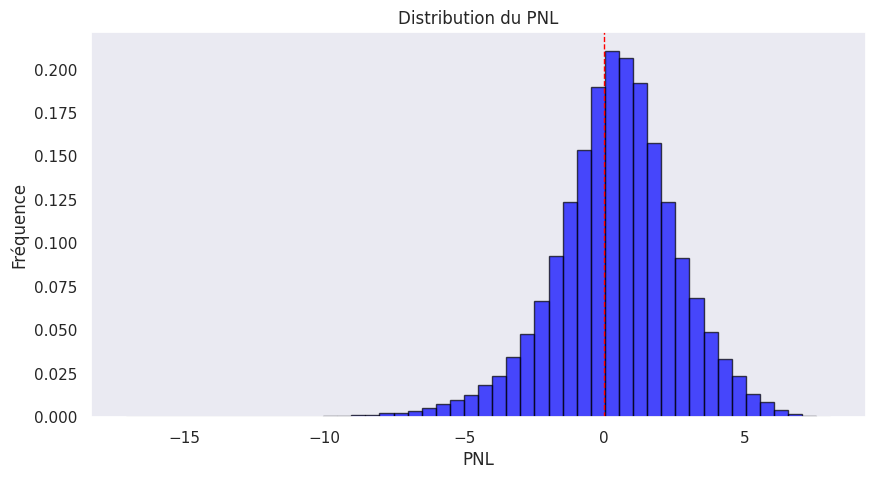

In [ ]:
plt.figure(figsize=(10, 5))

y_real = pnl_value(price_call_BS(x0, T), X, X_scaled, hedge_functions)

plt.hist(y_real.detach().numpy(), bins=50, color="blue", alpha=0.7, edgecolor="black", density=True)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)

plt.xlabel("PNL")
plt.ylabel("Fréquence")
plt.title("Distribution du PNL")
plt.grid()
plt.show()

In [ ]:
print(f'Mean : {y_real.detach().numpy().mean()}, Std : {y_real.detach().numpy().std()}')

Mean : 0.40190085768699646, Std : 2.2208919525146484


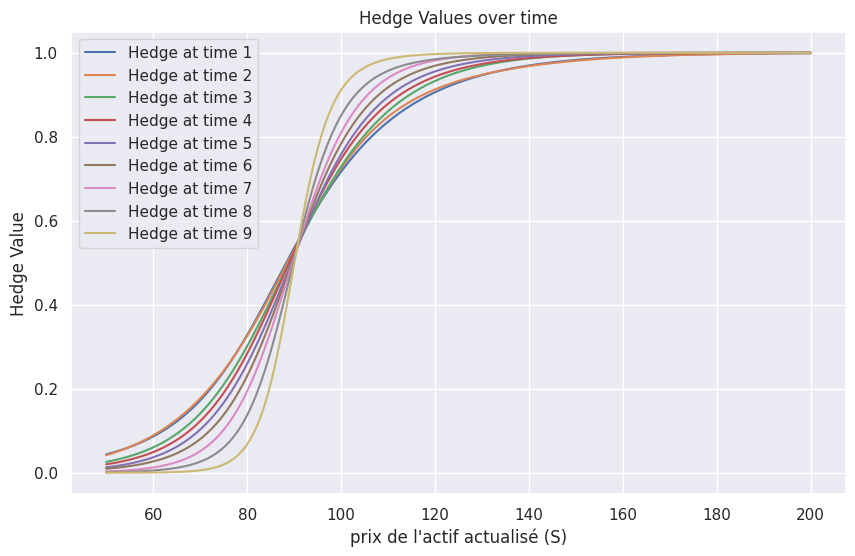

In [ ]:
X = np.linspace(50, 200, 1000)
xx = torch.from_numpy(X.astype(np.float32)).to(device)

xx_scaled = (xx - mean_val)/std_val
plt.figure(figsize=(10, 6))
for i in range(1, N):
    hedge_function = hedge_functions[i]
    hedge_output = hedge_function(xx_scaled[:,None]).detach().cpu().numpy()
    plt.plot(X, hedge_output, label=f"Hedge at time {i}")

plt.legend()
plt.xlabel("prix de l'actif actualisé (S)")
plt.ylabel("Hedge Value")
plt.title("Hedge Values over time")
plt.grid(True)
plt.show()

## Observation des résultats

On crée une fonction qui généralise la procédure précédente, et qui affiche aussi les couvertures en delta classique.

In [ ]:
learning_param = {'n_epochs': 20, 'batch_size': 4*1024,'learning_rate': 1e-3}

def train_and_see(N, learning_param = learning_param, nn_shape = [32, 32], plot_ = True):
    n_epochs = learning_param['n_epochs']
    batch_size = learning_param['batch_size']
    learning_rate = learning_param['learning_rate']

    samples = simu_S(N+1, M)
    samples_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * samples
    X = torch.from_numpy(samples_act.astype(np.float32)).to(device)

    mean_val = X.mean()
    std_val = X.std()
    X_scaled = (X - mean_val)/(std_val)

    hedge_functions = [NeuralNetwork(1, nn_shape, 1).to(device) for _ in range(N+1)]

    optimizer = torch.optim.Adam(
    [param for hedge_function in hedge_functions for param in hedge_function.parameters()],
    lr=learning_rate, weight_decay = 1e-4)

    criterion = nn.MSELoss()

    with tqdm(range(n_epochs)) as nrange:
        for n in nrange:
            indexes = torch.randperm(M)

            for k in range(M // batch_size):
                  idx = indexes[k * batch_size : (k + 1) * batch_size]

                  y_real = pnl_value(price_call_BS(x0, T), X[:,idx], X_scaled[:,idx], hedge_functions)
                  y_obj = torch.zeros_like(y_real)

                  loss = criterion(y_real, y_obj)

                  optimizer.zero_grad()

                  loss.backward()
                  optimizer.step()
                  loss.item()
            nrange.set_postfix(loss=loss.item())


    print(f'Mean : {y_real.detach().numpy().mean()}, Std : {y_real.detach().numpy().std()}')

    if plot_:
        plt.figure(figsize=(10, 6))
        y_real = pnl_value(price_call_BS(x0, T), X, X_scaled, hedge_functions)
        plt.hist(y_real.detach().numpy(), bins=50, color="blue", alpha=0.7, edgecolor="black", density=True)
        plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label="0")
        plt.xlabel("PnL", fontsize=14)
        plt.ylabel("fréquence", fontsize=14)
        plt.title("distribution du PnL (NN)", fontsize=16)
        plt.grid(True)
        plt.legend()
        plt.show()

        X = np.linspace(50, 200, 1000)
        xx = torch.from_numpy(X.astype(np.float32)).to(device)
        xx_scaled = (xx - mean_val) / std_val

        plt.figure(figsize=(10, 6))
        for i in range(1, N):
            hedge_function = hedge_functions[i]
            hedge_output = hedge_function(xx_scaled[:, None]).detach().cpu().numpy()
            # X*np.exp(r*T*(i/N)) puisqu'on travaillait jusque la avec X actualisé
            plt.plot(X*np.exp(r*T*(i/N)), hedge_output, label=f"Couverture en t{i}", alpha=0.6)

        if N < 15:
            plt.legend()
        plt.xlabel("Prix de l'actif (S)", fontsize=14)
        plt.ylabel("Couverture", fontsize=14)
        plt.title("Évolution des couvertures au cours du temps (NN)", fontsize=16)
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        for n in range(1, N):
            plt.plot(X, dprice_call_BS(xx, (N - n) * T / N), label=f"Couverture en t{n}", alpha=0.6)

        if N < 15:
            plt.legend()
        plt.xlabel("Prix de l'actif (S)", fontsize=14)
        plt.ylabel("Couverture (delta du Call)", fontsize=14)
        plt.title("Couverture basées sur la dérivée du call", fontsize=16)
        plt.grid(True)
        plt.show()

---

100%|██████████| 20/20 [00:23<00:00,  1.18s/it, loss=5.11]


Mean : 0.3814186155796051, Std : 2.2282357215881348


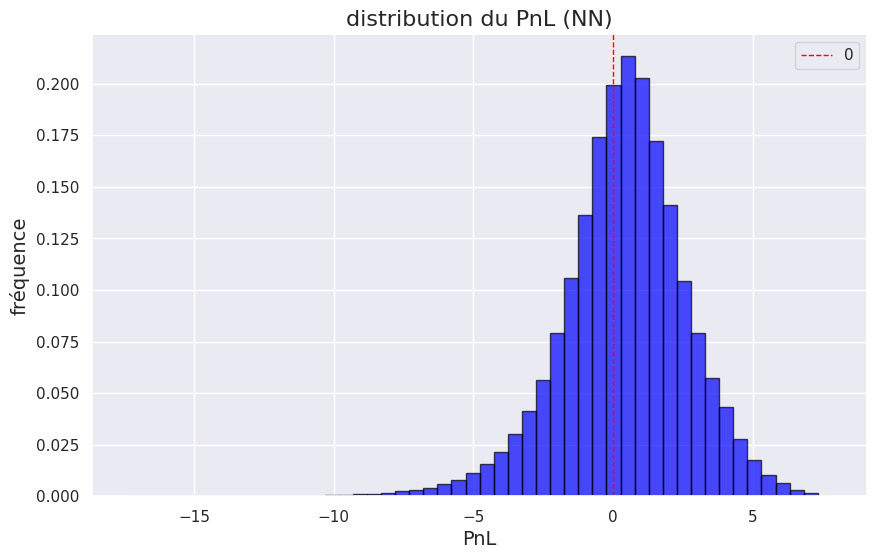

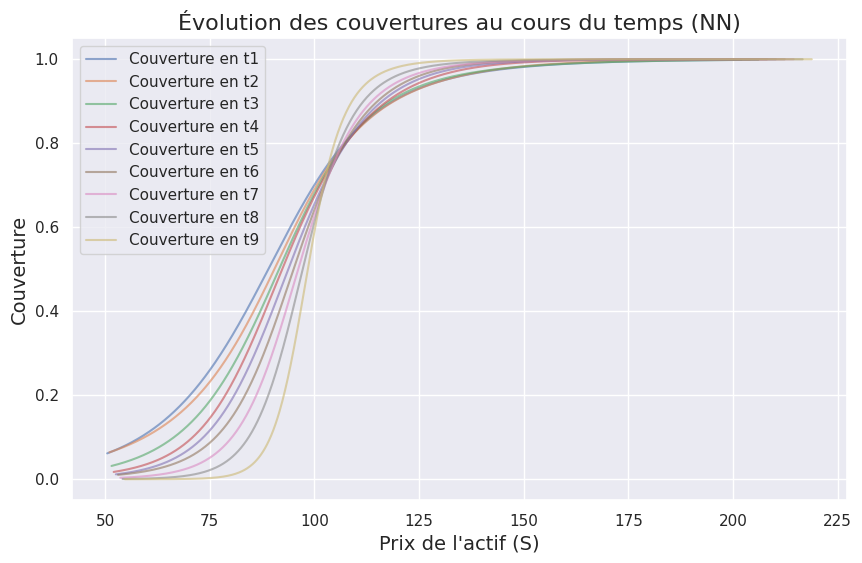

<ipython-input-4-65196f795843>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))


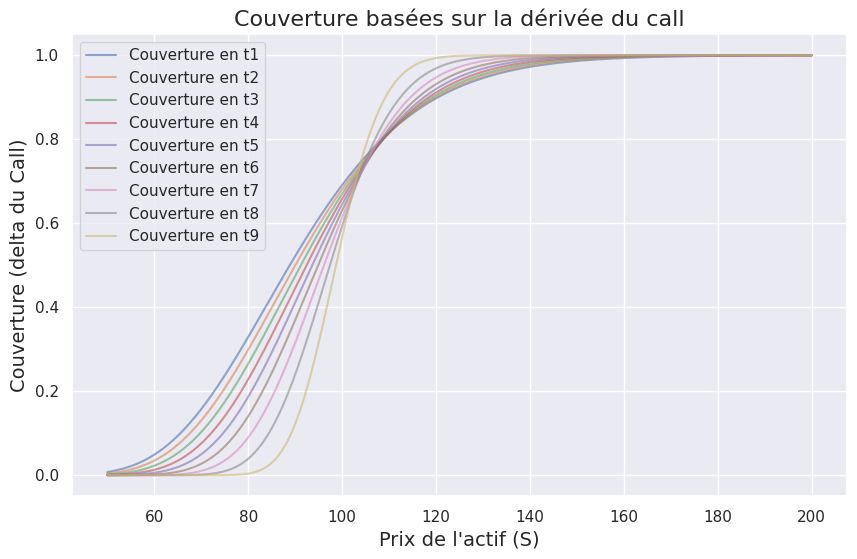

In [ ]:
learning_param = {'n_epochs': 20, 'batch_size': 4*1024,'learning_rate': 1e-3}
train_and_see(10, learning_param, nn_shape = [32, 32])

100%|██████████| 20/20 [03:05<00:00,  9.29s/it, loss=0.636]


Mean : 0.04456345736980438, Std : 0.7964894771575928


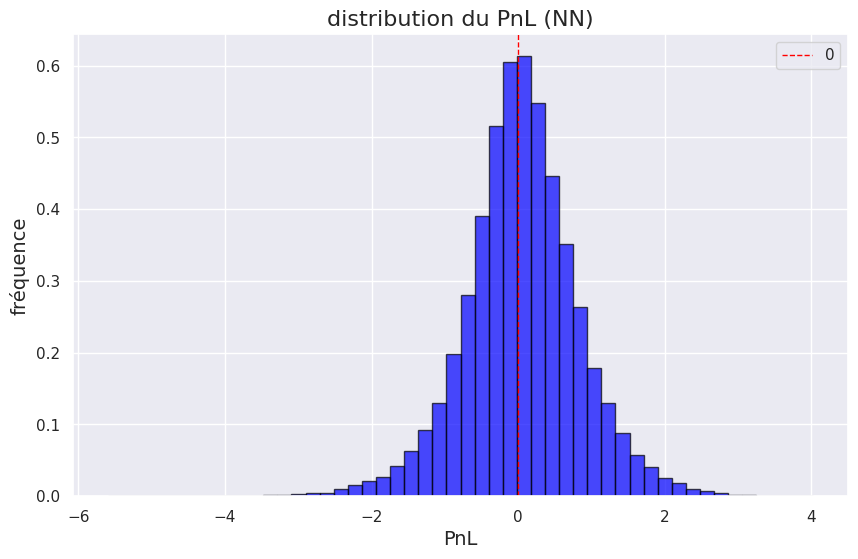

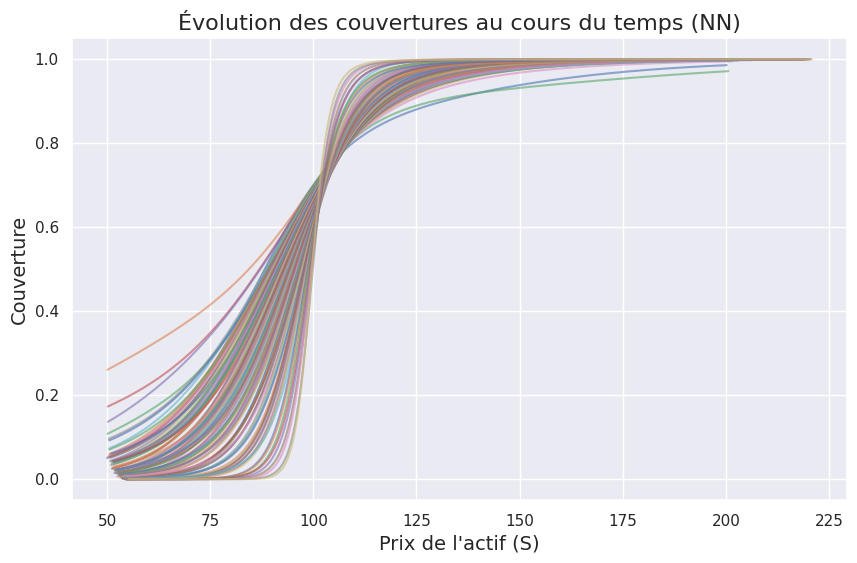

<ipython-input-4-65196f795843>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))


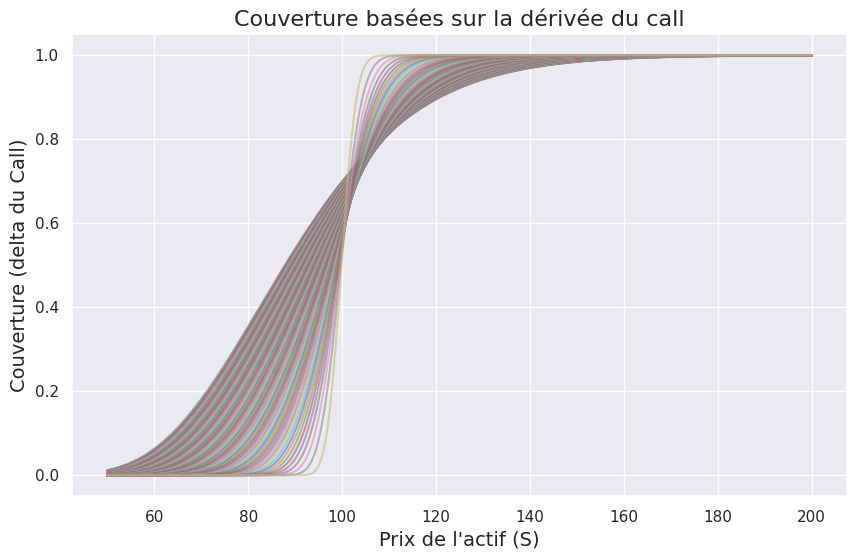

In [ ]:
learning_param = {'n_epochs': 20, 'batch_size': 4*1024,'learning_rate': 1e-3}
train_and_see(100, learning_param, nn_shape = [32, 32])

100%|██████████| 30/30 [08:47<00:00, 17.58s/it, loss=0.358]


Mean : 0.030135683715343475, Std : 0.5979596376419067


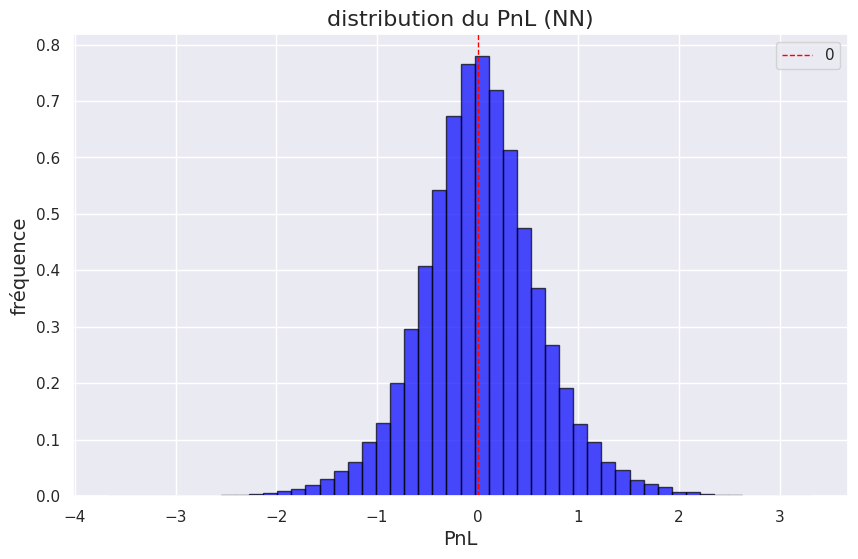

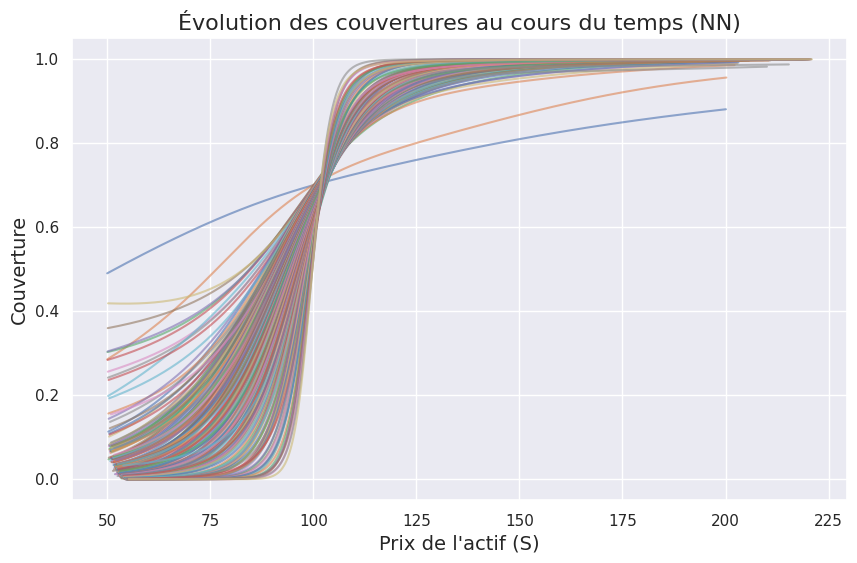

<ipython-input-4-65196f795843>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))


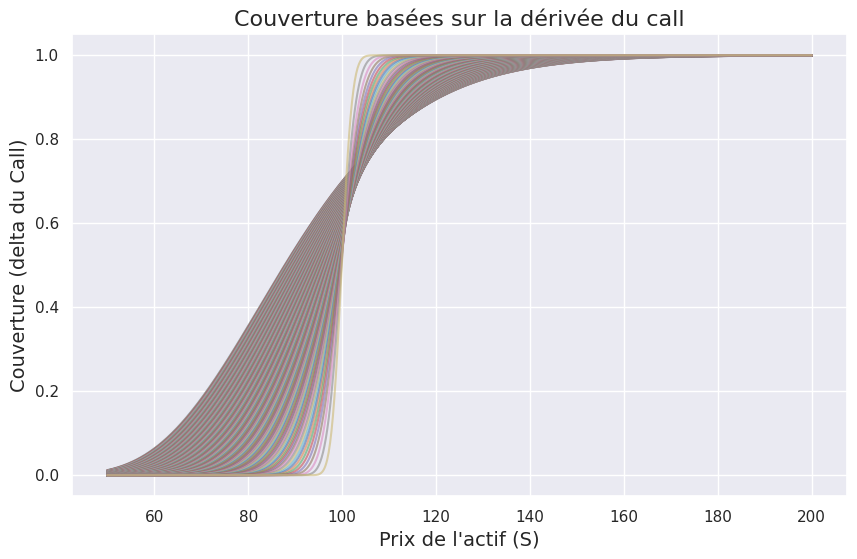

In [ ]:
learning_param = {'n_epochs': 30, 'batch_size': 4*1024,'learning_rate': 1e-3}
train_and_see(200, learning_param, nn_shape = [16, 16])

## **Commentaire**

La converture obtenue avec les réseaux de neurones et la couverture classique sont **très similaires**. Les différences notables résident dans les stratégies de couvertures aux premiers instants (valeurs de t proches de 0) : le réseau de neuronne semble faire un choix "moins radical" en fonction de la valeur de S. Les courbes sont plus proche de l'horizontal : les premières variations du prix n'ont pas d'effets significatifs sur la repartition de valeur du portefeuille.

Comme attendu, plus N est grand, plus la variance du PnL est petite, et plus la moyenne du PnL est proche de 0.